In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np

In [2]:
# Fetching project from signac workspace
project = signac.get_project()

C:\Users\Nilay\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


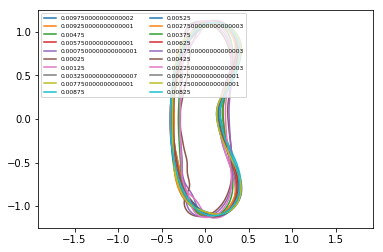

(20, 35)
(20, 80)


In [3]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
4. The section additionally plots wing imaginal disc shape through reverse EFD  as a result of changes made in the parameter
"""


# Defining number of input parameters and number of outputs in the feature 
num_samples = 20
num_harmonics = 20
num_input_parameter = 35

# Initializing input and output data
master_parameter_input = np.zeros([1, 35])
master_feature_output = np.zeros([1,80])

# Itearting throgh each job in workspace
for job in project:
    
    # Fetching input parameters from the .json file containing setpoints
    input_param = job.statepoint()["parameter_model"]
    # Coverting array to a numpy array
    input_param = np.array(input_param)
    # Reshaping the array to concatenate to the master input 
    input_param_reshaped = np.reshape(input_param, (1, len(input_param)))
    # Vertical concatenation of the job specific input parameter list to the mster input data
    master_parameter_input = np.vstack((master_parameter_input,input_param_reshaped))
    
    # Fetching efd coefficients from the output data in signac
    efd_coeff = job.document.get("e_f_d")
    # Converting to numpy array
    efd_coeff = np.array(efd_coeff)
    # Converting efd coeff to xy data for visualization
    xt, yt = spatial_efd.inverse_transform(efd_coeff, harmonic=20)
    plt.plot(xt,yt,label=str(input_param[33]))
    plt.axes().set_aspect('equal', 'datalim')
    # Reshaping efd coeff in a shape of a row 
    efd_coeff = np.reshape(efd_coeff, (1,80))
    # Stacking output features for creating a master output feature matrix
    master_feature_output = np.vstack((master_feature_output,efd_coeff))
   

plt.legend(loc='upper left',ncol = 2, prop={'size': 6})      
plt.show()

# Deleting the first row containing zeros
master_feature_output = np.delete(master_feature_output, 0, 0)
master_parameter_input = np.delete(master_parameter_input, 0, 0)

# Debug zone
print(np.shape(master_parameter_input))
print(np.shape(master_feature_output))
#print(master_feature_output)



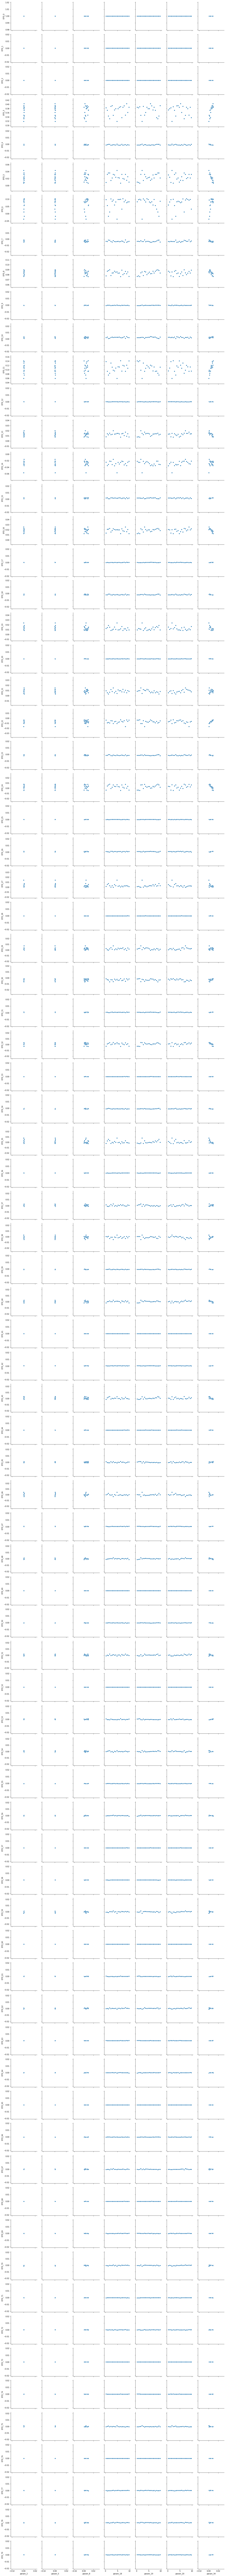

In [4]:
"""This section is meant to describe the correlations between the input parameter space and the output EFD features describing shape
   a) dataframes were created for the input and output data
   b) seaborn.pairplot was used to visualize correlations between EFD coefficients and input parameters
   c) Definition of parameters varied in LHS
       i) param_2 - T_squamous_basal
       ii) param_5 - T_cuboidal_basal
       iii) param_8 - T_columnar_basal
       iv) param_18 - k_columnar_basal
       v) param_19 - k_columnar_apical
       vi) param_20 - k_columnar_lateral
       vii) param_34 - k_ecm
"""
# Defining labels for the EFD coefficients
efd_labels = ["EFD_0"]
for i in range(1,4*num_harmonics):
    label_to_append = "EFD_"+str(i)
    efd_labels.append(label_to_append)
# Creating dataframe for the output shape feature matrix
df_output_features = pd.DataFrame(master_feature_output, columns = efd_labels)


# Defining labels for the parameters
parameter_labels = ["param_1"]
for i in range(1,35):
    label_to_append = "param_"+str(i+1)
    parameter_labels.append(label_to_append)
# Creatiing dataframe for the inpur parameters    
df_input_parameters = pd.DataFrame(master_parameter_input, columns = parameter_labels)

# merging in the input and output dataframes  
df_input_output_merged = pd.concat([df_output_features, df_input_parameters], axis=1)

# Importing seaborn library
import seaborn as sns
# Creating a pairplot for visualizing correlation
snsplot = sns.pairplot(
              df_input_output_merged,
              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],
              y_vars = efd_labels
          )
# Saving plot to a file
snsplot.savefig("correlation_param_efd.png")


[0.45084905 0.177921   0.13970589 0.0692342 ]


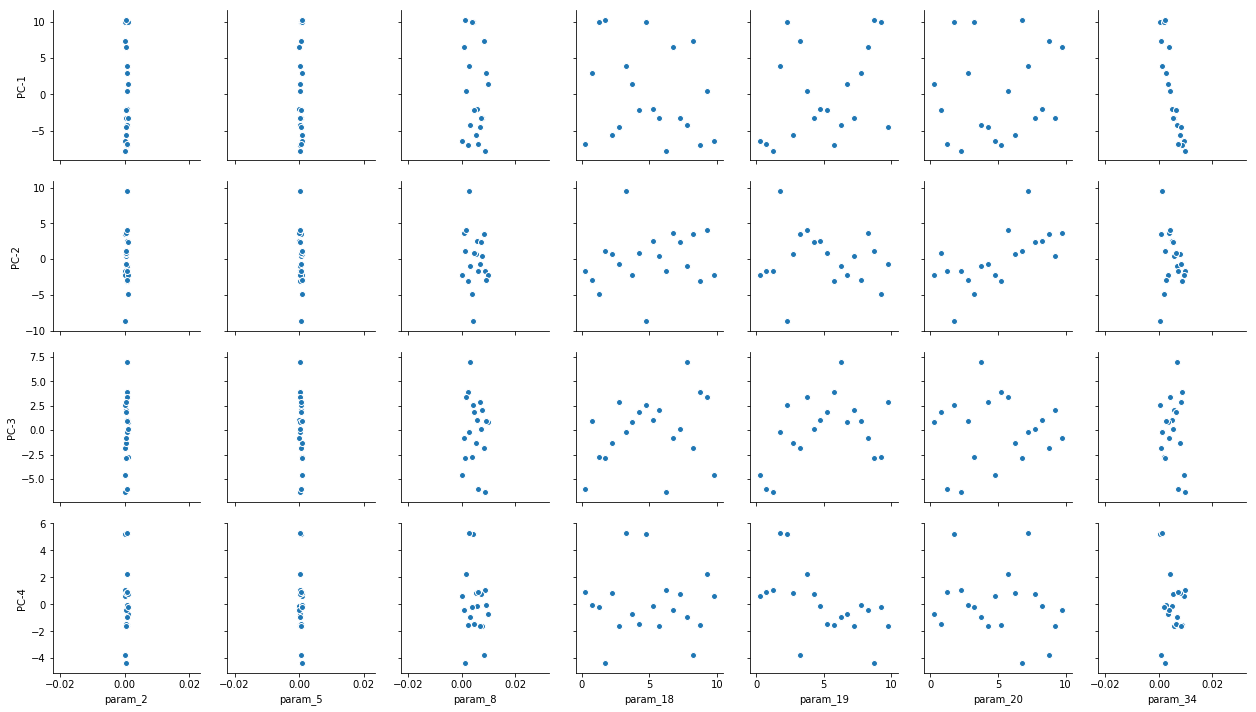

In [5]:
""" A) his section of code proejects the feature space into lower dimensions using PCA
b) Scikit learn was first used to normalize the data and then take principal components
c) Varaince captured in the principal components is also estimated
d) Further the section plots the correlations between KECM and different principal components
"""
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Storing the feature output data in x
x = master_feature_output
# Normalizing the data
x = StandardScaler().fit_transform(x)
# Defining number of components in PCA
pca = PCA(n_components=4)
# Using scikit learn to calculate PCs
principalComponents = pca.fit_transform(x)
# Variance explained in the principal components
print(pca.explained_variance_ratio_)

pc_labels = ["PC-1", "PC-2", "PC-3", "PC-4"]
df_output_pc = pd.DataFrame(principalComponents, columns = pc_labels)

df_input_output_pc_merged = pd.concat([df_output_pc, df_input_parameters], axis=1)

import seaborn as sns
snsplot = sns.pairplot(
              df_input_output_pc_merged,
              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],
              y_vars = pc_labels
          )

snsplot.savefig("correlation_param_efd_pc.png")


**Surrogate modeling**

A)Input: Parameters varoied in LHS

B) PCs of the EFD shape features
Build individual models relating the Input parameters to the individual PCs of EFD features

In [6]:
""" Importing librarie
"""

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
""" TRSAINING AND TESTING DATA FOR GPR MODEL
    a) This section of the code prepares the training data for the GPR model.
    b) Parameter that were varied during the LHS rae chosen as the input variables to the model.
    c) Output training data are the PCs of the PCs of the EFD features
    d) A split is carried out in the inut and output data to create a training and testing dataset for model
    
"""

# Number of parameters in the Latin Hypercube sampling
num_parameters_LHS = 7
param_index = [1, 4, 7, 17, 18, 19, 33]
split_size = 15
# Initializing the training data
train_x_numpy = np.zeros((num_samples, num_parameters_LHS))
# Getting the parameter values from master_parameter_input
for i in range(num_parameters_LHS):
    train_x_numpy[:,i] = master_parameter_input[:,param_index[i]]

""" Training data"""
# Converting numpy array to tensor
train_x = torch.from_numpy(train_x_numpy[:15,:])
# Converting the output training data to numpy array
# PC1
train_y1 = torch.from_numpy(principalComponents[:split_size,0])
# PC2
train_y2 = torch.from_numpy(principalComponents[:split_size,1])
# PC3
train_y3 = torch.from_numpy(principalComponents[:split_size,2])
# PC4 
train_y4 = torch.from_numpy(principalComponents[:split_size,3])

""" Testing data """
test_x = torch.from_numpy(train_x_numpy[split_size:num_samples,:])
test_y1 = principalComponents[split_size:num_samples,0]
test_y2 = principalComponents[split_size:num_samples,1]
test_y3 = principalComponents[split_size:num_samples,2]
test_y4 = principalComponents[split_size:num_samples,3]


In [8]:
""" This section of the code calculates the likelihood based on RBF Kernel
    ExactGPModels are defined 
    A) Model 1: Input: Parameters, Output: PC1
    B) Model 2: Input: Parameters, Output: PC1
    C) Model 3: Input: Parameters, Output: PC1
    D) Model 4: Input: Parameters, Output: PC1
"""

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Defining models for GPR
model1 = ExactGPModel(train_x, train_y1, likelihood)
model2 = ExactGPModel(train_x, train_y1, likelihood)
model3 = ExactGPModel(train_x, train_y1, likelihood)
model4 = ExactGPModel(train_x, train_y1, likelihood)

In [9]:
"""
Training the GP models: 
A) GPyTorch was used to fit a GP with RBF Kernel
B) The simplest likelihood for regression is the gpytorch.likelihoods.GaussianLikelihood.
This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).

"""

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000

"""
TRAINING MODEL 1

"""

# Find optimal model hyperparameters
model1.train()
likelihood.train()

# Use the adam optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model1)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer1.zero_grad()
    # Output from model
    output = model1(train_x)
    # Calc loss and backprop gradients
    loss = -mll1(output, train_y1)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model1.covar_module.base_kernel.lengthscale.item(),
        model1.likelihood.noise.item()
    ))
    optimizer1.step()

Iter 1/1000 - Loss: 13.814   lengthscale: 0.693   noise: 0.693
Iter 2/1000 - Loss: 12.915   lengthscale: 0.644   noise: 0.744
Iter 3/1000 - Loss: 12.123   lengthscale: 0.600   noise: 0.798
Iter 4/1000 - Loss: 11.423   lengthscale: 0.559   noise: 0.854
Iter 5/1000 - Loss: 10.802   lengthscale: 0.524   noise: 0.911
Iter 6/1000 - Loss: 10.247   lengthscale: 0.493   noise: 0.970
Iter 7/1000 - Loss: 9.749   lengthscale: 0.466   noise: 1.031
Iter 8/1000 - Loss: 9.300   lengthscale: 0.443   noise: 1.092
Iter 9/1000 - Loss: 8.894   lengthscale: 0.424   noise: 1.155
Iter 10/1000 - Loss: 8.527   lengthscale: 0.406   noise: 1.218
Iter 11/1000 - Loss: 8.195   lengthscale: 0.392   noise: 1.282
Iter 12/1000 - Loss: 7.895   lengthscale: 0.379   noise: 1.345
Iter 13/1000 - Loss: 7.624   lengthscale: 0.367   noise: 1.409
Iter 14/1000 - Loss: 7.378   lengthscale: 0.357   noise: 1.473
Iter 15/1000 - Loss: 7.155   lengthscale: 0.348   noise: 1.536
Iter 16/1000 - Loss: 6.952   lengthscale: 0.340   noise: 1

Iter 258/1000 - Loss: 3.560   lengthscale: 0.269   noise: 6.360
Iter 259/1000 - Loss: 3.558   lengthscale: 0.269   noise: 6.371
Iter 260/1000 - Loss: 3.557   lengthscale: 0.269   noise: 6.381
Iter 261/1000 - Loss: 3.555   lengthscale: 0.269   noise: 6.392
Iter 262/1000 - Loss: 3.554   lengthscale: 0.269   noise: 6.403
Iter 263/1000 - Loss: 3.552   lengthscale: 0.269   noise: 6.413
Iter 264/1000 - Loss: 3.551   lengthscale: 0.269   noise: 6.424
Iter 265/1000 - Loss: 3.550   lengthscale: 0.269   noise: 6.434
Iter 266/1000 - Loss: 3.548   lengthscale: 0.269   noise: 6.445
Iter 267/1000 - Loss: 3.547   lengthscale: 0.269   noise: 6.455
Iter 268/1000 - Loss: 3.545   lengthscale: 0.269   noise: 6.465
Iter 269/1000 - Loss: 3.544   lengthscale: 0.269   noise: 6.476
Iter 270/1000 - Loss: 3.543   lengthscale: 0.269   noise: 6.486
Iter 271/1000 - Loss: 3.541   lengthscale: 0.269   noise: 6.497
Iter 272/1000 - Loss: 3.540   lengthscale: 0.269   noise: 6.507
Iter 273/1000 - Loss: 3.539   lengthscal

Iter 514/1000 - Loss: 3.358   lengthscale: 0.268   noise: 8.544
Iter 515/1000 - Loss: 3.357   lengthscale: 0.268   noise: 8.551
Iter 516/1000 - Loss: 3.357   lengthscale: 0.268   noise: 8.558
Iter 517/1000 - Loss: 3.356   lengthscale: 0.268   noise: 8.565
Iter 518/1000 - Loss: 3.356   lengthscale: 0.268   noise: 8.572
Iter 519/1000 - Loss: 3.355   lengthscale: 0.268   noise: 8.579
Iter 520/1000 - Loss: 3.355   lengthscale: 0.268   noise: 8.586
Iter 521/1000 - Loss: 3.355   lengthscale: 0.268   noise: 8.593
Iter 522/1000 - Loss: 3.354   lengthscale: 0.268   noise: 8.600
Iter 523/1000 - Loss: 3.354   lengthscale: 0.268   noise: 8.607
Iter 524/1000 - Loss: 3.353   lengthscale: 0.268   noise: 8.614
Iter 525/1000 - Loss: 3.353   lengthscale: 0.268   noise: 8.620
Iter 526/1000 - Loss: 3.353   lengthscale: 0.268   noise: 8.627
Iter 527/1000 - Loss: 3.352   lengthscale: 0.268   noise: 8.634
Iter 528/1000 - Loss: 3.352   lengthscale: 0.268   noise: 8.641
Iter 529/1000 - Loss: 3.351   lengthscal

Iter 769/1000 - Loss: 3.284   lengthscale: 0.268   noise: 10.105
Iter 770/1000 - Loss: 3.284   lengthscale: 0.268   noise: 10.111
Iter 771/1000 - Loss: 3.284   lengthscale: 0.268   noise: 10.116
Iter 772/1000 - Loss: 3.284   lengthscale: 0.268   noise: 10.121
Iter 773/1000 - Loss: 3.283   lengthscale: 0.268   noise: 10.127
Iter 774/1000 - Loss: 3.283   lengthscale: 0.268   noise: 10.132
Iter 775/1000 - Loss: 3.283   lengthscale: 0.268   noise: 10.138
Iter 776/1000 - Loss: 3.283   lengthscale: 0.268   noise: 10.143
Iter 777/1000 - Loss: 3.283   lengthscale: 0.268   noise: 10.148
Iter 778/1000 - Loss: 3.282   lengthscale: 0.268   noise: 10.154
Iter 779/1000 - Loss: 3.282   lengthscale: 0.268   noise: 10.159
Iter 780/1000 - Loss: 3.282   lengthscale: 0.268   noise: 10.164
Iter 781/1000 - Loss: 3.282   lengthscale: 0.268   noise: 10.170
Iter 782/1000 - Loss: 3.282   lengthscale: 0.268   noise: 10.175
Iter 783/1000 - Loss: 3.281   lengthscale: 0.268   noise: 10.180
Iter 784/1000 - Loss: 3.2

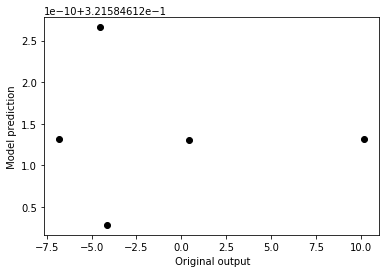

In [10]:
"""
This section of the code makes prediction for the trained GP model
"""

# Get into evaluation (predictive posterior) mode
model1.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred1 = likelihood(model1(test_x))
    
with torch.no_grad():
    # Calculating upper and lower bounds of model predictions
    lower1, upper1 = observed_pred1.confidence_region()
    # converting upper and lower bound prediction sto numpy array
    lower1_numpy = lower1.numpy()
    upper1_numpy = upper1.numpy()
    # Claculating mean prediction
    output_model_predictions_1 = observed_pred1.mean.numpy()
    # fetching actual output data
    original_outout = test_y1

# Plotting model predictions for PC1
plt.plot(original_outout , output_model_predictions_1, 'o', color='black')
plt.xlabel(" Original output")
plt.ylabel(" Model prediction ")
plt.show()